In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mpl_toolkits.basemap import Basemap, cm
import pyowm
import time

In [25]:
with open('owm-api-key.txt', 'r') as key_file:
    key = key_file.read()

owm = pyowm.OWM(key)

In [17]:
cities = pd.read_csv("cities.csv", ';')
valid_cities = []

In [18]:
dic = owm.city_id_registry()
for index, row in cities.iterrows():
    lookup = dic.locations_for(row['City'])
    if lookup==[]:
        print(row['City'])
    else:
        valid_cities.append(lookup[0])

Friedrichshafen
Freiburg
Stuttgart
Wuerzburg
Pforzheim
Crailsheim
Ulm
Memmingen
Augsburg
Rotthalmunster
Muenchen
Regensburg
Bayreuth
Nuremberg
Zwickau
Cottbus
Chemnitz
Leipzig
Erfurt
Magdeburg
Frankfurt am Main
Marburg
Kaiserslautern
Koblenz
Kassel
Bonn
Dusseldorf
Meppen
Berlin
Dortmund
Muenster
Bielefeld
Hannover
Bremen
Hamburg
Kiel
Rostock
Aachen
Fulda
Tor
Suez
Cairo
El Arish
Port Said
Alexandria
Marsa Matruh
Remada
Tataouine
Mellita
Kebili
Sfax
Sidi Bouzid
Mahdia
Thala
El Kef
Enfidha
Enfidha
Beja
Adrar
Timimoun
El Golea
Hassi Messaoud
Bechar
Ghardaïa
Ghardaïa
Ain Sefra
El Oued
El Bayadh
Mecheria
Laghouat
Djelfa
Biskra
Maghnia
Sidi Bel Abbes
Bou Saâda
Bou Saâda
Ksar Chellala
Relizane
Oran
Khenchela
Setif
Algiers
Constantine
Bouira
Ténès
Ténès
Bejaia
Annaba
Ceuta
Errachidia
Midelt
Beni-Mellal
Nouaceur
Casablanca
Meknes
Rabat
Taza
Al Hoceima
Chefchaouene
Tabuk
Al Qurayyat
Aqaba
At Tafilah
Amman
Irbid
Tel Aviv
Haifa
Tripoli
Beirut
Damascus
Hama
Latakia
Al Hasakah
Yerevan
Gyumri
Tbilisi


In [19]:
lon = []
lat = []
for city in valid_cities:
    lon.append(city.get_lon())
    lat.append(city.get_lat())

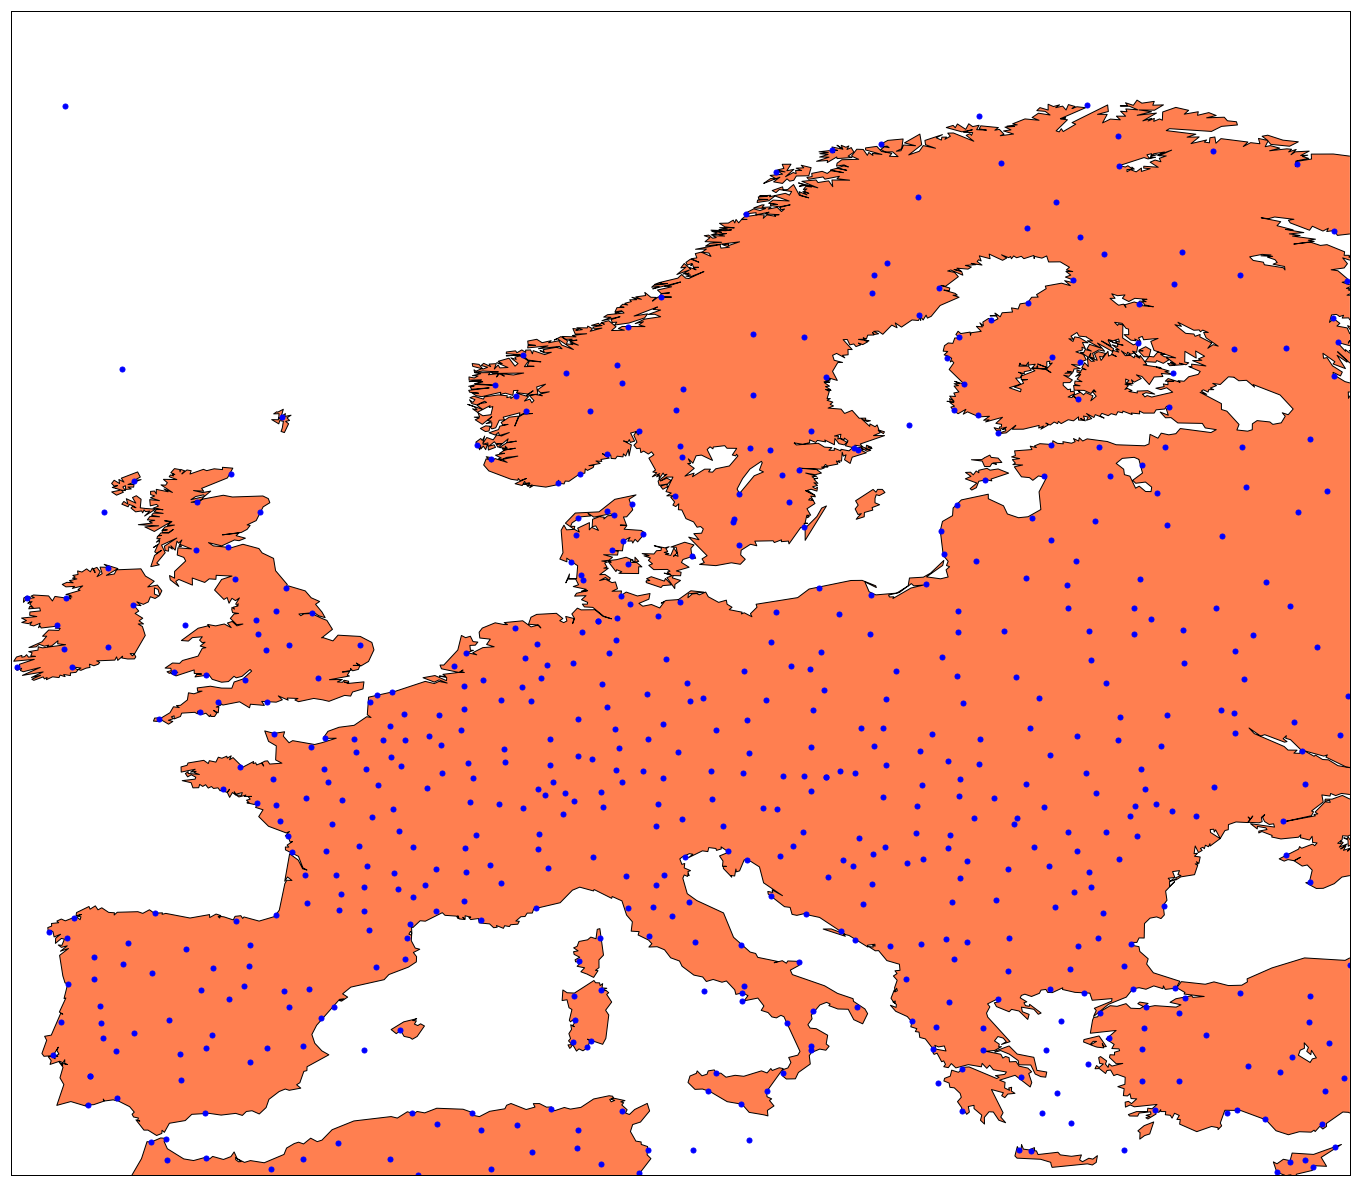

In [20]:
plt.figure(figsize=(24,24))
map = Basemap(llcrnrlon=-10.56,llcrnrlat=34.65,urcrnrlon=34.88,urcrnrlat=74.17, resolution = 'l', epsg=4668)
map.drawmapboundary(fill_color='white')
map.fillcontinents(color='coral',lake_color='white')
map.drawcoastlines()
x, y = map(lon, lat)
map.plot(x, y, 'bo', markersize=5)



In [21]:
ids = []
for city in valid_cities:
    ids.append(city.get_ID())
    

In [26]:
observation_list = []
id20s = []
elt_id20 = []
c = 0
for c in range(0, len(ids)):
    elt_id20.append(ids[c])
    if len(elt_id20) == 20 or c == len(ids)-1:
        id20s.append(elt_id20)
        elt_id20 = []
    c = c + 1

for id20 in id20s:
    observation_list.append(owm.weather_at_ids(id20))
    time.sleep(1)


In [27]:
weathers = []
for obss in observation_list:
    for obs in obss:
        weathers.append(obs.get_weather())

In [28]:
temps = []
for weather in weathers:
    temps.append(weather.get_temperature(unit='celsius'))

In [29]:
temps[0]['temp']

10.43

i_x = 0
i_x = 1
i_x = 2
i_x = 3
i_x = 4
i_x = 5
i_x = 6
i_x = 7
i_x = 8
i_x = 9
i_x = 10
i_x = 11
i_x = 12
i_x = 13
i_x = 14
i_x = 15
i_x = 16
i_x = 17
i_x = 18
i_x = 19
i_x = 20
i_x = 21
i_x = 22
i_x = 23
i_x = 24
i_x = 25
i_x = 26
i_x = 27
i_x = 28
i_x = 29
i_x = 30
i_x = 31
i_x = 32
i_x = 33
i_x = 34
i_x = 35
i_x = 36
i_x = 37
i_x = 38
i_x = 39
i_x = 40
i_x = 41
i_x = 42
i_x = 43
i_x = 44
i_x = 45
i_x = 46
i_x = 47
i_x = 48
i_x = 49
i_x = 50
i_x = 51
i_x = 52
i_x = 53
i_x = 54
i_x = 55
i_x = 56
i_x = 57
i_x = 58
i_x = 59
i_x = 60
i_x = 61
i_x = 62
i_x = 63
i_x = 64
i_x = 65
i_x = 66
i_x = 67
i_x = 68
i_x = 69
i_x = 70
i_x = 71
i_x = 72
i_x = 73
i_x = 74
i_x = 75
i_x = 76
i_x = 77
i_x = 78
i_x = 79
i_x = 80
i_x = 81
i_x = 82
i_x = 83
i_x = 84
i_x = 85
i_x = 86
i_x = 87
i_x = 88
i_x = 89
i_x = 90
i_x = 91
i_x = 92
i_x = 93
i_x = 94
i_x = 95
i_x = 96
i_x = 97
i_x = 98
i_x = 99


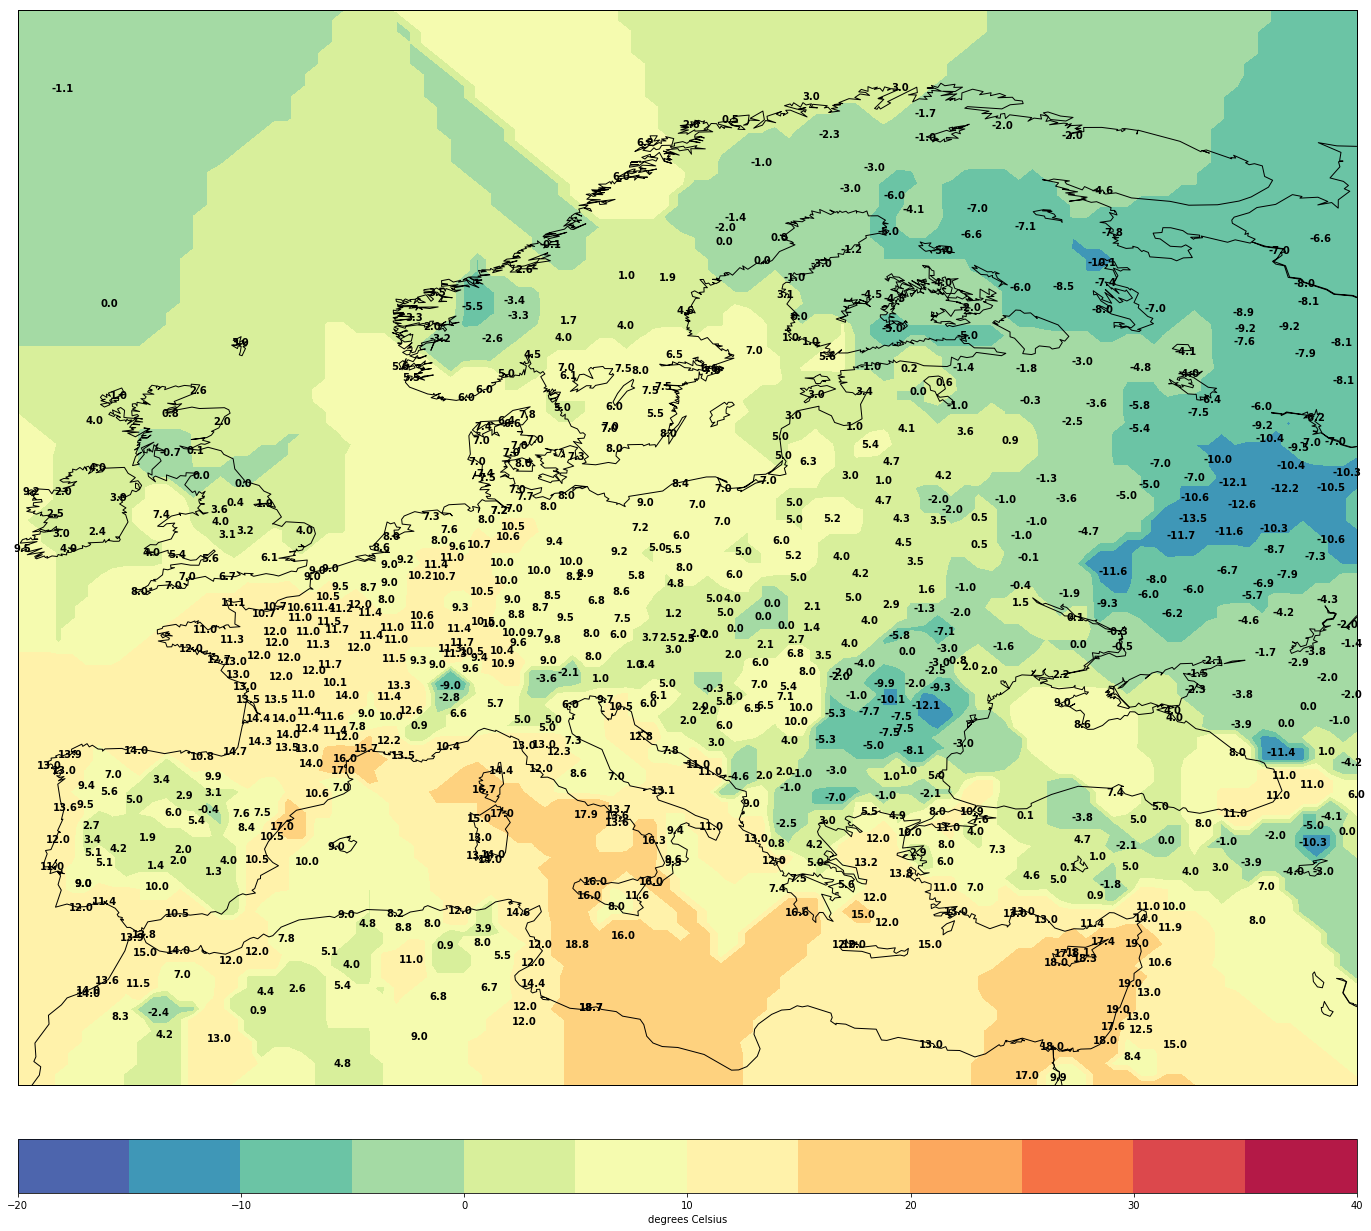

In [30]:
lon_min = -10.56
lat_min = 29.65
lon_max = 44.88
lat_max = 74.17

x_in_bounds = []
y_in_bounds = []
temps_in_bounds = []

plt.figure(figsize=(24,24))
map = Basemap(llcrnrlon=lon_min,llcrnrlat=lat_min,urcrnrlon=lon_max,urcrnrlat=lat_max, resolution = 'l', epsg=4668)
map.drawmapboundary(fill_color='white')
#map.fillcontinents(color='coral',lake_color='white')
map.drawcoastlines()
x, y = map(lon, lat)
for i in range(0,len(x)-1):
    if lon[i] > lon_min and lon[i] < lon_max and lat[i] > lat_min and lat[i] < lat_max:
        plt.text(x[i], y[i], "{0:.1f}".format(temps[i]['temp']),fontsize=10,fontweight='bold', ha='center',va='center',color='k')
        x_in_bounds.append(x[i])
        y_in_bounds.append(y[i])
        temps_in_bounds.append(temps[i]['temp'])

nx = 100
ny = 100
glons, glats = map.makegrid(nx, ny)
gx, gy = map(glons, glats)

#Interpolation

#Dummy
data = np.zeros((nx, ny))

#Nearest neighbor with plane euclidian distance
for i_x in range(0, nx):
    print('i_x = %d' % i_x)
    for i_y in range(0, ny):
        distance_to_closest = 0
        idx_closest = -1
        distance = 0
        for it in range(0, len(lon)):
            distance = (glons[i_x][i_y]-lon[it])**2 + (glats[i_x][i_y]-lat[it])**2
            if (idx_closest < 0):
                distance_to_closest = distance
                idx_closest = it
            elif (distance_to_closest > distance):
                distance_to_closest = distance
                idx_closest = it
        data[i_x][i_y] = temps[idx_closest]['temp']

    
clevs = [-20,-15,-10,-5,0,5,10,15,20,25,30,35,40]
cs = map.contourf(gx,gy,data,clevs,cmap='Spectral_r')

cbar = map.colorbar(cs,location='bottom',pad="5%")
cbar.set_label('degrees Celsius')
